$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Neural Networks

*Type your name here and rewrite all of the following sections.  Add more sections to present your code, results, and discussions.*

## Overview

You will write and apply code that trains neural networks of various numbers of hidden layers and units in each hidden layer and returns results as specified below.  You will do this once for a regression problem and once for a classification problem. 

## Required Code

Download [nn2.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/nn2.tar) that was used in lecture and extract its contents, which are

* `neuralnetworks.py`
* `scaledconjugategradient.py`
* `mlutils.py`

Write the following functions that train and evaluate neural network models.

* `results = trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify)`

The arguments to `trainNNs` are

* `X` is a matrix of input data of shape `nSamples x nFeatures`
* `T` is a matrix of target data of shape `nSamples x nOutputs`
* `trainFraction` is fraction of samples to use as training data. 1-`trainFraction` is number of samples for testing data
* `hiddenLayerStructures` is list of network architectures. For example, to test two networks, one with one hidden layer of 20 units, and one with 3 hidden layers with 5, 10, and 20 units in each layer, this argument would be `[[20], [5, 10, 20]]`.
* `numberRepetitions` is number of times to train a neural network.  Calculate training and testing average performance (two separate averages) of this many training runs.
* `numberIterations` is the number of iterations to run the scaled conjugate gradient algorithm when a neural network is trained.
* `classify` is set to `True` if you are doing a classification problem, in which case `T` must be a single column of target class integers.

This function returns `results` which is list with one element for each network structure tested.  Each element is a list containing 

* the hidden layer structure (as a list),
* a list of training data performance for each repetition, 
* a list of testing data performance for each repetition, and
* the number of seconds it took to run this many repetitions for this network structure.

This function should follow these steps:

  * For each network structure given in `hiddenLayerStructures`
    * For numberRepetitions
      * Use `ml.partition` to randomly partition X and T into training and testing sets.
      * Create a neural network of the given structure
      * Train it for numberIterations
      * Use the trained network to produce outputs for the training and for the testing sets
      * If classifying, calculate the fraction of samples incorrectly classified for training and testing sets.
       Otherwise, calculate the RMSE of training and testing sets.
      * Add the training and testing performance to a collection (such as a list) for this network structure
    * Add to a collection of all results the hidden layer structure, lists of training performance and testing performance, and seconds taken to do these repetitions.
  * return the collection of all results

Also write the following two functions. `summarize(results)` returns a list of lists like `results` but with the list of training performances replaced by their mean and the list of testing performances replaced by their mean.   
`bestNetwork(summary)` takes the output of `summarize(results)` and returns the best element of `results`, determined by the element that has the smallest test performance.

* `summary = summarize(results)` where `results` is returned by `trainNNs` and `summary` is like `results` with the training and testing performance lists replaced by their means
* `best = bestNetwork(summary)` where `summary` is returned by `summarize` and `best` is the best element of `summary`

In [53]:
# Replace this cell with several cells defining the above functions.

## Examples


In [54]:
import neuralnetworks as nn
import numpy as np
import math
import random
import time
import sys
import copy
from statistics import mean
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

I have a few helper methods that help my trainNNs functions. Cases for classifier and regular network are handeled seperately.

In [55]:
def findRMSE(targets, tested):
    #print(tested)
    result = 0;
    
    
    #if a.shape[1] == 1:
    #    for x in range(0,len(targets)):
    #       result +=  (targets[x]-tested[x])**2 
    cols = len(targets[0])
    
    for c in range(0,cols):
        for x in range(0,len(targets)):
            result +=  (targets[x][c]-tested[x][c])**2 
    
    
    result = result / len(targets)
    result = math.sqrt(result) 
    return result
    

In [56]:
def findPercentIncorrect(targets, tested):
    numIncorrect = 0;
    for x in range(0,len(targets)):
        if round( float(targets[x])) != round( float(tested[x])) : 
            #print(str(targets[x]) + " " + str(tested[x]) + "\n")
            numIncorrect += 1
    
    result = float(numIncorrect)/float(len(targets))
    
    return result
    

In [57]:
def splitIntoSets(X,T,b):
    
    
    
    dataSize = len(X)
    split = dataSize*b
    split = int(split)
    testX = X[split:]
    trainX = X[:split]
    testT = T[split:]
    trainT = T[:split]
    
    
    
    
    return trainX, testX, trainT, testT
    

In [107]:
def trainONE_NN(X, T, trainFraction, hiddenLayerStructure, numberRepetitions, numberIterations, classify):
    
    trainingPerformances = []
    testingPerformances = []
    
    start_time = time.time()
    
    trainX, testX, trainT, testT = splitIntoSets(X,T,trainFraction)
    
    for k in range(0,numberRepetitions):
        #X,T = shuffle(X,T)
        nnet = 'hi'
        """
        trainX = np.asanyarray(trainX)
        trainT = np.asanyarray(trainT)
        testX = np.asanyarray(testX)
        testT = np.asanyarray(testT)
        """
        if not classify:
            nnet = nn.NeuralNetwork(trainX.shape[1], hiddenLayerStructure, trainT.shape[1])
            nnet.train(trainX, trainT, numberIterations)
        else:
            nnet = nn.NeuralNetworkClassifier(trainX.shape[1], hiddenLayerStructure, len(np.unique(trainT)))
            nnet.train(trainX, trainT, numberIterations)
        #rint(trainX.shape)
        #print(trainT.shape)
        
        
        trainRes = nnet.use(trainX)
        testRes = nnet.use(testX)
        
        if classify: 
            trainingPerformances.append(findPercentIncorrect(trainT,trainRes))
            testingPerformances.append(findPercentIncorrect(testT,testRes))
        else: 
            trainingPerformances.append(findRMSE(trainT,trainRes))
            testingPerformances.append(findRMSE(testT,testRes))
    end_time = time.time()
    
    exec_time = float(end_time - start_time)

    result = [hiddenLayerStructure, trainingPerformances, testingPerformances, exec_time]
    
    return result
    

In [108]:
def trainNNs(X, T, trainFraction, hiddenLayerStructures, numberRepetitions, numberIterations, classify=False):
    results = []
    
    for hl in hiddenLayerStructures:
        results.append(trainONE_NN(X, T, trainFraction, hl, numberRepetitions, numberIterations, classify))
        
    return results

In [109]:
def summarize(data):
    results = copy.deepcopy(data)
    for x in range(0,len(results)):
        results[x][1] = mean(np.asarray(results[x][1]))
        results[x][2] = mean(np.asarray(results[x][2]))
    return results

In [110]:
def bestNetwork(summary):
    result = summary[0]
    for x in range(0,len(summary)):
        if result[2] > summary[x][2]: result = summary[x]
    return result
    
    

In [111]:
X = np.arange(10).reshape((-1,1))
T = X + 1 + np.random.uniform(-1, 1, ((10,1)))
findRMSE(X,T)
trX, teX, trT, teT = splitIntoSets(X, T, .8)
#trX, teX, trT, teT
x = findPercentIncorrect(X,T)
x

0.6

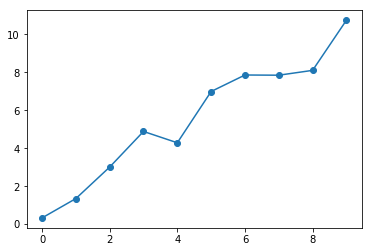

In [112]:
plt.plot(X, T, 'o-');

In [113]:
nnet = nn.NeuralNetwork(X.shape[1], 2, T.shape[1])
nnet.train(X, T, 100)
nnet.getErrorTrace()

array([0.70710678, 0.50234939, 0.50234939, 0.50234939, 0.50234939,
       0.50234939, 0.50234939, 0.50234939, 0.50234939, 0.50234939,
       0.47613602, 0.27370548, 0.23283212, 0.21843243, 0.20720304,
       0.20720296, 0.18437984, 0.17763017, 0.15934538, 0.15883789,
       0.15520656, 0.1502126 , 0.14932203, 0.14918906, 0.14902288,
       0.14828353, 0.14818106, 0.14782317, 0.14782317, 0.14782317,
       0.14782317, 0.14782317, 0.14782317, 0.14457819, 0.14457353,
       0.14254118, 0.14217876, 0.14189598, 0.14186082, 0.14184616,
       0.14155789, 0.1408697 , 0.1398186 , 0.13967982, 0.13962461,
       0.13926191, 0.13915716, 0.13879338, 0.13866669, 0.13858383,
       0.13850451, 0.13842149, 0.13836685, 0.13784733, 0.13740977,
       0.13658154, 0.13641097, 0.13638485, 0.13623642, 0.13533621,
       0.13528327, 0.13509062, 0.1350581 , 0.1350306 , 0.13499865,
       0.13478568, 0.13400379, 0.13383938, 0.13364526, 0.13359895,
       0.13355733, 0.13346222, 0.13275117, 0.1325642 , 0.13222

In [114]:
nnet = nn.NeuralNetwork(X.shape[1], [50, 50, 50], T.shape[1])
nnet.train(X, T, 1000)
nnet.getErrorTrace()
y = nnet.use(X)
y

array([[ 0.32845783],
       [ 1.34829112],
       [ 3.01051725],
       [ 4.88861355],
       [ 4.29054753],
       [ 6.9941109 ],
       [ 7.86416656],
       [ 7.853555  ],
       [ 8.10831265],
       [10.75150351]])

In [115]:
T

array([[ 0.32845781],
       [ 1.34829117],
       [ 3.01051718],
       [ 4.88861366],
       [ 4.2905475 ],
       [ 6.99411092],
       [ 7.8641665 ],
       [ 7.85355499],
       [ 8.10831268],
       [10.7515035 ]])

In [117]:
results = trainONE_NN(X, T, 0.8, [10,10,10], 5, 100, classify=True)
results

[[10, 10, 10],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.5, 0.5, 0.5, 0.5, 0.5],
 0.24650311470031738]

In [118]:
results = trainNNs(X, T, 0.8, [2, 10, [10, 10]], 5, 100, classify=False)
results

[[2,
  [0.49772561783315217,
   0.5264504035705818,
   0.2411634271003566,
   0.4922800757728135,
   0.3004333970513479],
  [1.8724166377084244,
   1.4137319833351638,
   2.0530372325766866,
   1.5581459518301093,
   1.9936948333422586],
  0.09545278549194336],
 [10,
  [0.29528096505293694,
   0.02566863684717227,
   0.10264578338357663,
   0.0038691335912375583,
   0.027076545383365794],
  [2.6858795492253345,
   1.9993732838393024,
   1.9900360007300317,
   2.167339029556072,
   2.147588879755244],
  0.09732627868652344],
 [[10, 10],
  [0.06282001883572379,
   0.058925062242788075,
   0.2839632733163406,
   0.0697445529925147,
   0.20259735963494818],
  [2.2019412514266787,
   2.056771477943888,
   2.9297626653027637,
   2.0873139866735677,
   2.542040296791863],
  0.11320209503173828]]

In [38]:
results = trainNNs(X, T, 0.8, [0, 1, 2, 10, [10, 10], [5, 5, 5, 5], [2]*5], 50, 100, classify=False)

In [39]:
suma = summarize(results)
suma

[[0, 0.4812622947261798, 1.0210183939134123, 0.02415013313293457],
 [1, 0.42275110399698934, 1.8552686201087543, 0.7249083518981934],
 [2, 0.0909007251397965, 1.5429529647755191, 0.7905778884887695],
 [10, 0.036047622271155044, 1.7908838736604107, 0.9047350883483887],
 [[10, 10], 0.04762587405012592, 1.481521108706116, 1.350658893585205],
 [[5, 5, 5, 5], 0.11716973304803475, 1.3238276555488455, 1.682868242263794],
 [[2, 2, 2, 2, 2],
  0.31615685053628106,
  1.6497408179417354,
  1.7714626789093018]]

In [40]:
best = bestNetwork(summarize(results))
print(best)
print('Hidden Layers {} Average RMSE Training {:.2f} Testing {:.2f} Took {:.2f} seconds'.format(*best))

[0, 0.4812622947261798, 1.0210183939134123, 0.02415013313293457]
Hidden Layers 0 Average RMSE Training 0.48 Testing 1.02 Took 0.02 seconds


Hummm...neural nets with no hidden layers did best on this simple data set.  Why?  Remember what "best" means.

Linear regression

In [41]:
X = np.random.uniform(-1, 1, (100, 3))
T = np.hstack(((X**2 - 0.2*X**3).sum(axis=1,keepdims=True),
               (np.sin(X)).sum(axis=1,keepdims=True)))
result = trainNNs(X, T, 0.7, [0, 5, 10, [20, 20]], 10, 100, False)

In [42]:
result

[[0,
  [0.4908326515629898,
   0.4908326515629898,
   0.4908326515629898,
   0.4908326515629898,
   0.4908326515629898,
   0.4908326515629898,
   0.4908326515629898,
   0.4908326515629898,
   0.4908326515629898,
   0.4908326515629898],
  [0.5126260584685797,
   0.5126260584685797,
   0.5126260584685797,
   0.5126260584685797,
   0.5126260584685797,
   0.5126260584685797,
   0.5126260584685797,
   0.5126260584685797,
   0.5126260584685797,
   0.5126260584685797],
  0.014941692352294922],
 [5,
  [0.1483494457483631,
   0.12212667522487959,
   0.15009862396775372,
   0.1095190366805673,
   0.0819409976631901,
   0.12549419536296091,
   0.09164802904295676,
   0.11409501454189738,
   0.11461418994421148,
   0.18289688876276333],
  [0.17089017640526807,
   0.13467436176905356,
   0.20738746289436974,
   0.18333581678896252,
   0.13119695721749006,
   0.16084495712141614,
   0.1351616112334943,
   0.18468156827828236,
   0.14098671507163962,
   0.2556051218377592],
  0.2542538642883301],
 [1

## Data for Regression Experiment

From the UCI Machine Learning Repository, download the [Appliances energy prediction](http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction) data.  You can do this by visiting the Data Folder for this data set, or just do this:

     !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv



Read this data into python.  One suggestion is to use the `loadtxt` function in the `numpy` package.  You may ignore the first column of each row which contains a data and time.  Also ignore the last two columns of random variables.  We will not use that in our modeling of this data.  You will also have to deal with the double quotes that surround every value in every field.  Read the first line of this file to get the names of the features.

Once you have read this in correctly, you should see values like this:

In [24]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv
    

--2018-11-05 19:26:09--  http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11979363 (11M) [text/csv]
Saving to: ‘energydata_complete.csv.5’

energydata_complete 100%[===================>]  11.42M  8.01MB/s    in 1.4s    

2018-11-05 19:26:11 (8.01 MB/s) - ‘energydata_complete.csv.5’ saved [11979363/11979363]



In [25]:
import csv
T = [ [], []]
X = []

for a in range(0,26):
    X.append([])

    
with open('energydata_complete.csv') as csvfile:
    reader = csv.reader(csvfile)
    
    
    names = reader.__next__()
    #print(reader.__next__())
    for row in reader:
        T[0].append(float(row[1]))
        T[1].append(float(row[2]))
    
        for y in range(3,len(row)):
            X[y-3].append(float(row[y]))
    #print(reader.__next__())
    #print(reader.__next__())
print((T))

[[60.0, 60.0, 50.0, 50.0, 60.0, 50.0, 60.0, 60.0, 60.0, 70.0, 230.0, 580.0, 430.0, 250.0, 100.0, 100.0, 90.0, 70.0, 80.0, 140.0, 120.0, 190.0, 110.0, 110.0, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 400.0, 400.0, 390.0, 240.0, 60.0, 60.0, 60.0, 50.0, 70.0, 60.0, 40.0, 40.0, 30.0, 40.0, 50.0, 310.0, 380.0, 380.0, 370.0, 120.0, 50.0, 40.0, 50.0, 40.0, 50.0, 50.0, 50.0, 40.0, 40.0, 30.0, 20.0, 20.0, 40.0, 50.0, 50.0, 40.0, 50.0, 40.0, 40.0, 40.0, 60.0, 50.0, 50.0, 40.0, 40.0, 40.0, 40.0, 50.0, 70.0, 40.0, 30.0, 20.0, 30.0, 40.0, 50.0, 60.0, 60.0, 70.0, 60.0, 140.0, 110.0, 90.0, 60.0, 60.0, 60.0, 50.0, 60.0, 50.0, 30.0, 40.0, 30.0, 260.0, 500.0, 450.0, 50.0, 60.0, 60.0, 50.0, 50.0, 50.0, 60.0, 60.0, 60.0, 60.0, 190.0, 220.0, 170.0, 390.0, 90.0, 60.0, 290.0, 130.0, 140.0, 240.0, 50.0, 60.0, 60.0, 60.0, 370.0, 200.0, 70.0, 50.0, 40.0, 40.0, 30.0, 30.0, 30.0, 30.0, 40.0, 50.0, 40.0, 40.0, 40.0, 60.0, 60.0, 210.0, 380.0, 370.0, 230.0, 80.0, 90.0, 70.0, 40.0, 40.0, 30.0, 50.0, 50.0, 60.0

In [26]:
names

['date',
 'Appliances',
 'lights',
 'T1',
 'RH_1',
 'T2',
 'RH_2',
 'T3',
 'RH_3',
 'T4',
 'RH_4',
 'T5',
 'RH_5',
 'T6',
 'RH_6',
 'T7',
 'RH_7',
 'T8',
 'RH_8',
 'T9',
 'RH_9',
 'T_out',
 'Press_mm_hg',
 'RH_out',
 'Windspeed',
 'Visibility',
 'Tdewpoint',
 'rv1',
 'rv2']

I already formatted the data by target and input when I read it in, so skip the two statements that were written here to look at the data, replace them with the inputs X

In [27]:
print(T)

[[60.0, 60.0, 50.0, 50.0, 60.0, 50.0, 60.0, 60.0, 60.0, 70.0, 230.0, 580.0, 430.0, 250.0, 100.0, 100.0, 90.0, 70.0, 80.0, 140.0, 120.0, 190.0, 110.0, 110.0, 110.0, 110.0, 100.0, 100.0, 100.0, 100.0, 110.0, 400.0, 400.0, 390.0, 240.0, 60.0, 60.0, 60.0, 50.0, 70.0, 60.0, 40.0, 40.0, 30.0, 40.0, 50.0, 310.0, 380.0, 380.0, 370.0, 120.0, 50.0, 40.0, 50.0, 40.0, 50.0, 50.0, 50.0, 40.0, 40.0, 30.0, 20.0, 20.0, 40.0, 50.0, 50.0, 40.0, 50.0, 40.0, 40.0, 40.0, 60.0, 50.0, 50.0, 40.0, 40.0, 40.0, 40.0, 50.0, 70.0, 40.0, 30.0, 20.0, 30.0, 40.0, 50.0, 60.0, 60.0, 70.0, 60.0, 140.0, 110.0, 90.0, 60.0, 60.0, 60.0, 50.0, 60.0, 50.0, 30.0, 40.0, 30.0, 260.0, 500.0, 450.0, 50.0, 60.0, 60.0, 50.0, 50.0, 50.0, 60.0, 60.0, 60.0, 60.0, 190.0, 220.0, 170.0, 390.0, 90.0, 60.0, 290.0, 130.0, 140.0, 240.0, 50.0, 60.0, 60.0, 60.0, 370.0, 200.0, 70.0, 50.0, 40.0, 40.0, 30.0, 30.0, 30.0, 30.0, 40.0, 50.0, 40.0, 40.0, 40.0, 60.0, 60.0, 210.0, 380.0, 370.0, 230.0, 80.0, 90.0, 70.0, 40.0, 40.0, 30.0, 50.0, 50.0, 60.0

In [28]:

X[0] = np.asanyarray(X[0])
X[1] = np.asanyarray(X[1])

for j in range(0,len(T)):
    T[j] = np.asanyarray(T[j])

X = np.asanyarray(X)
T = np.asanyarray(T)
X

array([[19.89      , 19.89      , 19.89      , ..., 25.5       ,
        25.5       , 25.5       ],
       [47.59666667, 46.69333333, 46.3       , ..., 46.59666667,
        46.99      , 46.6       ],
       [19.2       , 19.2       , 19.2       , ..., 25.62857143,
        25.414     , 25.26428571],
       ...,
       [ 5.3       ,  5.2       ,  5.1       , ..., 13.26666667,
        13.23333333, 13.2       ],
       [13.27543316, 18.60619498, 28.64266817, ..., 29.19911708,
         6.32278365, 34.11885059],
       [13.27543316, 18.60619498, 28.64266817, ..., 29.19911708,
         6.32278365, 34.11885059]])

In [29]:
print(X.shape)
T.shape

(26, 19735)


(2, 19735)

In [30]:
print(X[:,:])
T[:2,:]

[[19.89       19.89       19.89       ... 25.5        25.5
  25.5       ]
 [47.59666667 46.69333333 46.3        ... 46.59666667 46.99
  46.6       ]
 [19.2        19.2        19.2        ... 25.62857143 25.414
  25.26428571]
 ...
 [ 5.3         5.2         5.1        ... 13.26666667 13.23333333
  13.2       ]
 [13.27543316 18.60619498 28.64266817 ... 29.19911708  6.32278365
  34.11885059]
 [13.27543316 18.60619498 28.64266817 ... 29.19911708  6.32278365
  34.11885059]]


array([[ 60.,  60.,  50., ..., 270., 420., 430.],
       [ 30.,  30.,  30., ...,  10.,  10.,  10.]])

Use the first two columns, labelled `Appliances` and `lights` as the target variables, and the remaining 24 columns as the input features.  So

In [31]:
Xenergy, Tenergy = X.transpose(),T.transpose()

In [32]:
Xenergy.shape, Tenergy.shape

((19735, 26), (19735, 2))

Train several neural networks on all of this data for 100 iterations.  Plot the error trace (nnet.getErrorTrace()) to help you decide now many iterations might be needed.  100 may not be enough.  If for your larger networks the error is still decreasing after 100 iterations you should train all nets for more than 100 iterations.

Now use your `trainNNs`, `summarize`, and `bestNetwork` functions on this data to investigate various network sizes.

In [33]:
import matplotlib.pyplot as plt

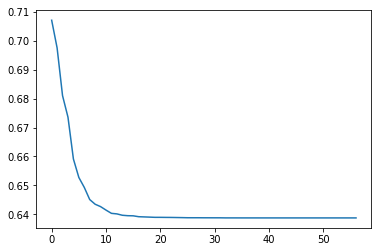

In [34]:
nnet = nn.NeuralNetwork(Xenergy.shape[1], 0, Tenergy.shape[1])
nnet.train(Xenergy, Tenergy, 500)
errorTrace = nnet.getErrorTrace()
plt.plot(errorTrace)
plt.show()

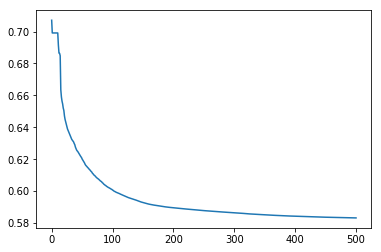

In [35]:
nnet = nn.NeuralNetwork(Xenergy.shape[1], 10, Tenergy.shape[1])
nnet.train(Xenergy, Tenergy, 500)
errorTrace = nnet.getErrorTrace()
plt.plot(errorTrace)
plt.show()

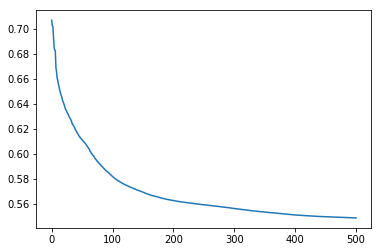

In [36]:
nnet = nn.NeuralNetwork(Xenergy.shape[1], [10,10], Tenergy.shape[1])
nnet.train(Xenergy, Tenergy, 500)
errorTrace = nnet.getErrorTrace()
plt.plot(errorTrace)
plt.show()

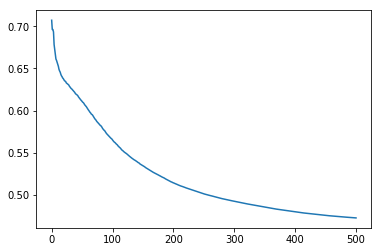

In [37]:
nnet = nn.NeuralNetwork(Xenergy.shape[1], [25,25], Tenergy.shape[1])
nnet.train(Xenergy, Tenergy, 500)
errorTrace = nnet.getErrorTrace()
plt.plot(errorTrace)
plt.show()

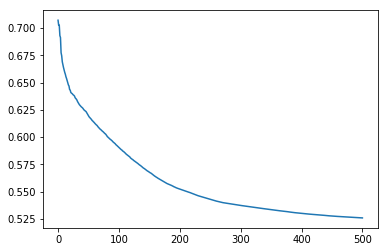

In [38]:
nnet = nn.NeuralNetwork(Xenergy.shape[1], [10,10,10], Tenergy.shape[1])
nnet.train(Xenergy, Tenergy, 500)
errorTrace = nnet.getErrorTrace()
plt.plot(errorTrace)
plt.show()

The error traces of all the networks here seem to be pretty slowly decreasing around 200-300 iterations. Therefore I will test my networks with 200 iterations. Note also that some of the large networks may keep decreasing with more iterations without actually improving performance on the testing data, because they start to overfit the data after being run for too long.

In [46]:
results = trainNNs(Xenergy, Tenergy, 0.8, [0, 5, 10, 20, [5, 5], [10, 10], [15,15], [2,2], [5,2,2], [10,5,5], [5,5,5]], 3, 200)

In [47]:
summarize(results)

[[0, 97.2009348011626, 86.72078986328988, 0.350147008895874],
 [5, 93.01883378289237, 91.70117876213544, 6.003739595413208],
 [10, 90.28916719819127, 102.01835878824028, 6.11672830581665],
 [20, 87.09890557299971, 99.9678516850114, 7.715023517608643],
 [[5, 5], 91.51301364270832, 98.66168057689421, 6.505074977874756],
 [[10, 10], 87.41833386076178, 109.54703994185343, 7.6416566371917725],
 [[15, 15], 81.7607123242829, 115.86899480479006, 10.29627513885498],
 [[2, 2], 95.71861767501449, 87.07916417144595, 5.196683645248413],
 [[5, 2, 2], 92.42642210786889, 99.19361546629997, 6.008453607559204],
 [[10, 5, 5], 84.45091147115104, 103.03659057101508, 9.147809267044067],
 [[5, 5, 5], 91.71464966915676, 94.33737248246476, 7.70161771774292]]

In [48]:
bestNetwork(summarize(results))

[0, 97.2009348011626, 86.72078986328988, 0.350147008895874]

It seems to be that the really big networks are overfitting the training data too much and doing badly on the testing data because of that.

In [49]:
trainX, testX, trainT, testT = splitIntoSets(Xenergy,Tenergy,.8)

nnet = nn.NeuralNetwork(trainX.shape[1], [0], trainT.shape[1])
nnet.train(trainX, trainT, 500)
res = nnet.use(testX)

[-0.62410906  0.00384913  0.4644066   0.51153932  0.23047117  0.36170846
 -0.11868909 -0.23705246 -0.20584715 -0.15345254]
[ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.]


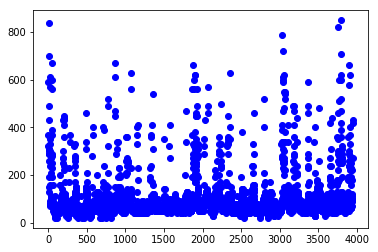

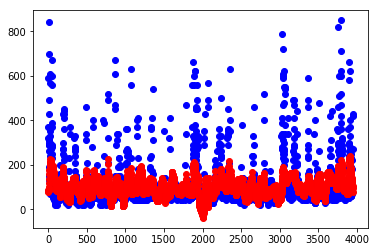

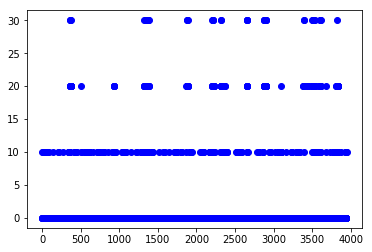

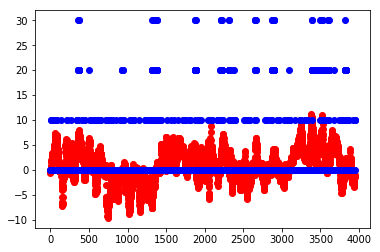

In [55]:

results = res.transpose()
TT = testT.transpose()
print(results[1][:10])
print(TT[1][:10])


plt.plot(TT[0], 'bo')
plt.show()

plt.plot(TT[0], 'bo')
plt.plot(results[0], 'ro')
plt.show()

plt.plot(TT[1], 'bo')
plt.show()

plt.plot(results[1], 'ro')
plt.plot(TT[1], 'bo')
plt.show()





The prediction graph for the appliances energy use seem to be pretty good, it was able to match some of the spikes in the data. For the lights energy use however, the prediction was really bad. I think that is because the lights energy use only has 4 different set values, and the neural network was having trouble approximating that with a continous function. 

Test at least 10 different hidden layer structures.  Larger numbers of layers and units may do the best on training data, but not on testing data. Why?

Now train another network with your best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date).  As before use `ml.partition` to produce the training and testing sets.

For the testing data, plot the predicted and actual `Appliances` energy use, and the predicted and actual `lights` energy use, in two separate plots.  Discuss what you see.

## Data for Classification Experiment

From the UCI Machine Learning Repository, download the [Anuran Calls (MFCCs)](http://archive.ics.uci.edu/ml/datasets/Anuran+Calls+%28MFCCs%29) data.  You can do this by visiting the Data Folder for this data set, or just do this:

     !wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip'
     !unzip Anuran*zip
     
Read the data in the file `Frogs_MFCCs.csv` into python.  This will be a little tricky. Each line of the file is a sample of audio features plus three columns that label the sample by family, genus, and species. We will try to predict the species.  The tricky part is that the species is given as text.  We need to convert this to a target class, as an integer. The `numpy` function `unique` will come in handy here.

In [42]:
!wget 'http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran Calls (MFCCs).zip' 
!unzip Anuran*zip

--2018-11-05 19:28:16--  http://archive.ics.uci.edu/ml/machine-learning-databases/00406/Anuran%20Calls%20(MFCCs).zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1300058 (1.2M) [application/zip]
Saving to: ‘Anuran Calls (MFCCs).zip’

Anuran Calls (MFCCs 100%[===================>]   1.24M  1.64MB/s    in 0.8s    

2018-11-05 19:28:17 (1.64 MB/s) - ‘Anuran Calls (MFCCs).zip’ saved [1300058/1300058]

Archive:  Anuran Calls (MFCCs).zip
  inflating: Frogs_MFCCs.csv         
  inflating: Readme.txt              


In [138]:
import csv
T = []
X = []



for a in range(0,22):
    X.append([])

    
with open('Frogs_MFCCs.csv') as csvfile:
    reader = csv.reader(csvfile)
    
    
    names = reader.__next__()
    #print(reader.__next__())
    for row in reader:
        #print(len(row))
        T.append(row[24])
    
        for y in range(0,22):
            #print(y)
            X[y].append(float(row[y]))
            

species = np.unique(np.asanyarray(T))

#print(species)

speConv = {}
num2spec = {}
for x in range(0,len(species)):
    speConv[species[x]] = x
    num2spec[x] = species[x]


In [139]:
for x in range(0,len(T)):
    T[x] = speConv[T[x]]
    

In [140]:
T = [T]
Xanuran = np.asanyarray(X)
Tanuran = np.asanyarray(T)

In [141]:
Xanuran = np.transpose(Xanuran)
Tanuran = np.transpose(Tanuran)

Everything above is pretty much just to get the input into the right form for the network training.

In [142]:
Tanuran

array([[0],
       [0],
       [0],
       ...,
       [9],
       [9],
       [9]])

In [143]:
Xanuran.shape, Tanuran.shape

((7195, 22), (7195, 1))

In [144]:
Xanuran[:2,:]

array([[ 1.        ,  0.1529363 , -0.1055859 ,  0.20072191,  0.31720106,
         0.26076385,  0.10094464, -0.1500626 , -0.17112763,  0.12467644,
         0.18865415, -0.07562172, -0.15643593,  0.08224512,  0.13575204,
        -0.02401665, -0.10835111, -0.07762252, -0.0095678 ,  0.05768398,
         0.11868014,  0.01403845],
       [ 1.        ,  0.17153426, -0.09897474,  0.26842522,  0.33867186,
         0.2683531 ,  0.06083509, -0.22247464, -0.20769267,  0.17088287,
         0.27095828, -0.09500394, -0.25434147,  0.02278623,  0.1633201 ,
         0.01202228, -0.09097401, -0.05650952, -0.03530336,  0.02013996,
         0.08226299,  0.02905574]])

In [145]:
Tanuran

array([[0],
       [0],
       [0],
       ...,
       [9],
       [9],
       [9]])

In [146]:
for i in range(10):
    print('{} samples in class {}'.format(np.sum(Tanuran==i), i))

672 samples in class 0
3478 samples in class 1
542 samples in class 2
310 samples in class 3
472 samples in class 4
1121 samples in class 5
270 samples in class 6
114 samples in class 7
68 samples in class 8
148 samples in class 9


In [147]:
results = trainNNs(Xanuran, Tanuran, 0.8, [0, 5, [5, 5]], 5, 100, classify=False)

In [148]:
summarize(results)

[[0, 0.7366786421317706, 3.1156362234508266, 0.27329421043395996],
 [5, 0.3429173548558209, 2.8977324082806217, 1.066497802734375],
 [[5, 5], 0.28445222291273914, 2.700037379684352, 1.454193115234375]]

In [149]:
bestNetwork(summarize(results))

[[5, 5], 0.28445222291273914, 2.700037379684352, 1.454193115234375]

Now do an investigation like you did for the regression data. 

Test at least 10 different hidden layer structures. Then train another network with your best hidden layer structure on 0.8 of the data and use the trained network on the testing data (the remaining 0.2 of the date). 

Plot the predicted and actual `Species` for the testing data as an integer.  Discuss what you see.

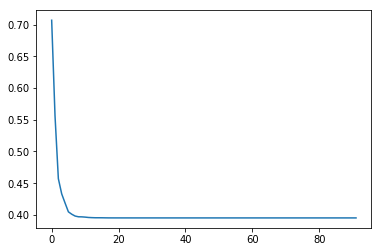

In [151]:
nnet = nn.NeuralNetwork(Xanuran.shape[1], 0, Tanuran.shape[1])
nnet.train(Xanuran, Tanuran, 500)
errorTrace = nnet.getErrorTrace()
plt.plot(errorTrace)
plt.show()

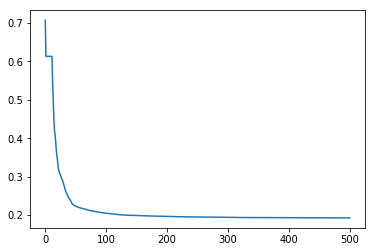

In [152]:
nnet = nn.NeuralNetwork(Xanuran.shape[1], 5, Tanuran.shape[1])
nnet.train(Xanuran, Tanuran, 500)
errorTrace = nnet.getErrorTrace()
plt.plot(errorTrace)
plt.show()

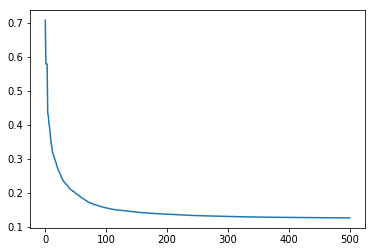

In [153]:
nnet = nn.NeuralNetwork(Xanuran.shape[1], 15, Tanuran.shape[1])
nnet.train(Xanuran, Tanuran, 500)
errorTrace = nnet.getErrorTrace()
plt.plot(errorTrace)
plt.show()

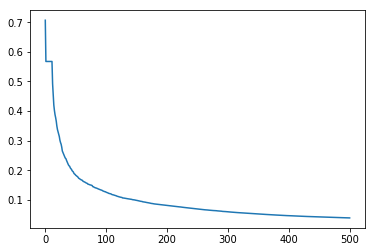

In [150]:
nnet = nn.NeuralNetwork(Xanuran.shape[1], [25,25], Tanuran.shape[1])
nnet.train(Xanuran, Tanuran, 500)
errorTrace = nnet.getErrorTrace()
plt.plot(errorTrace)
plt.show()

Networks seem to have fallen of pretty well by 100 iterations

In [154]:
results = trainNNs(Xanuran, Tanuran, 0.8, [0, 2, 5, 10, [2,2], [5, 5], [10,10], [15,15], [2,2,2], [5,5,5]], 5, 100, classify=False)

In [155]:
summarize(results)

[[0, 0.7366786421317706, 3.1156362234508266, 0.24059820175170898],
 [2, 0.5230283271410936, 2.8016465911579256, 0.9326446056365967],
 [5, 0.3356501870766392, 2.761383458218884, 1.7105474472045898],
 [10, 0.2867649630998246, 2.7188788878401566, 2.0415616035461426],
 [[2, 2], 0.4418094217314229, 2.7059119748738967, 1.1558303833007812],
 [[5, 5], 0.2829727573068849, 2.6241810105049526, 2.1256067752838135],
 [[10, 10], 0.21829928275197658, 2.746230597841125, 2.7190518379211426],
 [[15, 15], 0.1934706862352541, 2.8264149144835407, 3.2554407119750977],
 [[2, 2, 2], 0.46941618797054935, 2.598914918424834, 1.4406263828277588],
 [[5, 5, 5], 0.3207334070048697, 2.763797511743875, 2.4406659603118896]]

In [156]:
bestNetwork(summarize(results))

[[2, 2, 2], 0.46941618797054935, 2.598914918424834, 1.4406263828277588]

In [158]:
trainX, testX, trainT, testT = splitIntoSets(Xanuran,Tanuran,.8)

In [160]:

nnet = nn.NeuralNetwork(trainX.shape[1], [2,2,2], trainT.shape[1])
nnet.train(trainX, trainT, 100)
res = nnet.use(testX)


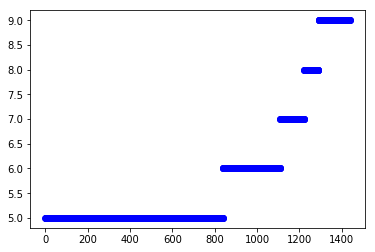

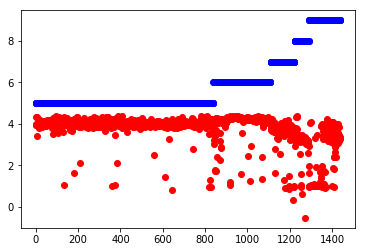

In [164]:

results = res.transpose()
TT = testT.transpose()
#print(results[1][:10])
#print(TT[1][:10])


plt.plot(TT[0], 'bo')
plt.show()

plt.plot(TT[0], 'bo')
plt.plot(results[0], 'ro')
plt.show()




Its totally messed up. I tried using the NN classifier class, but I ran into a lot of tuple errors inside some other file. So these are the graphs for the classifier trained as if it was not a classifier.

## Grading

Download [A5grader.tar](http://www.cs.colostate.edu/~anderson/cs440/notebooks/A5grader.tar) and extract `A5grader.py` from it.

In [165]:
#%run -i "A5grader.py"


======================= Code Execution =======================

Extracting python code from notebook named 'Darcy-A5.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing summarize([[[1,1], [1.2, 1.3, 1.4], [2.2, 2.3, 2.4], 0.5], [[2,2,2], [4.4, 4.3, 4.2], [6.5, 6.4, 6.3], 0.6]])

--- 10/10 points. Correctly returned [[[1, 1], 1.3, 2.3, 0.5], [[2, 2, 2], 4.3, 6.4, 0.6]]

Testing bestNetwork([[[1, 1], 1.3, 2.3, 0.5], [[2, 2, 2], 4.3, 1.3, 0.6]])

--- 10/10 points. Correctly returned [[2, 2, 2], 4.3, 1.3, 0.6]

X = np.random.uniform(-1, 1, (100, 3))
T = np.hstack(((X**2 - 0.2*X**3).sum(axis=1,keepdims=True),
               (np.sin(X)).sum(axis=1,keepdims=True)))
result = trainNNs(X, T, 0.7, [0, 5, 10, [20, 20]], 10, 100, False)

--- 20/20 points. Correct.

Testing bestNetwork(summarize(result))

--- 20/20 points. You correctly found that network [20, 20] is best.

cs440 Execution Grade is 60 / 60

===============

<Figure size 432x288 with 0 Axes>

## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A5.ipynb```.  So, for me it would be ```Anderson-A5.ipynb```.  Submit the file using the ```Assignment 5``` link on [Canvas](https://colostate.instructure.com/courses/68135).

## Extra Credit

  2. Repeat the above regression and classification experiments with a second regression data set and a second classification data set.
  
  2. Since you are collecting the performance of all repetitions for each network structure, you can calculate a confidence interval about the mean, to help judge significant differences. Do this for either the regression or the classification data and plot the mean test performance with confidence intervals for each network structure tested.  Discuss the statistical significance of the differences among the means.  One website I found to help with this is the site [Correct way to obtain confidence interval with scipy](https://stackoverflow.com/questions/28242593/correct-way-to-obtain-confidence-interval-with-scipy).
  
